In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib 

ModuleNotFoundError: No module named 'scanorama'

In [ ]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [ ]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [ ]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [147]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


In [148]:
adata_path = data_dir / "metadata" / f"combined_final.h5ad"
adata = sc.read_h5ad(adata_path)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


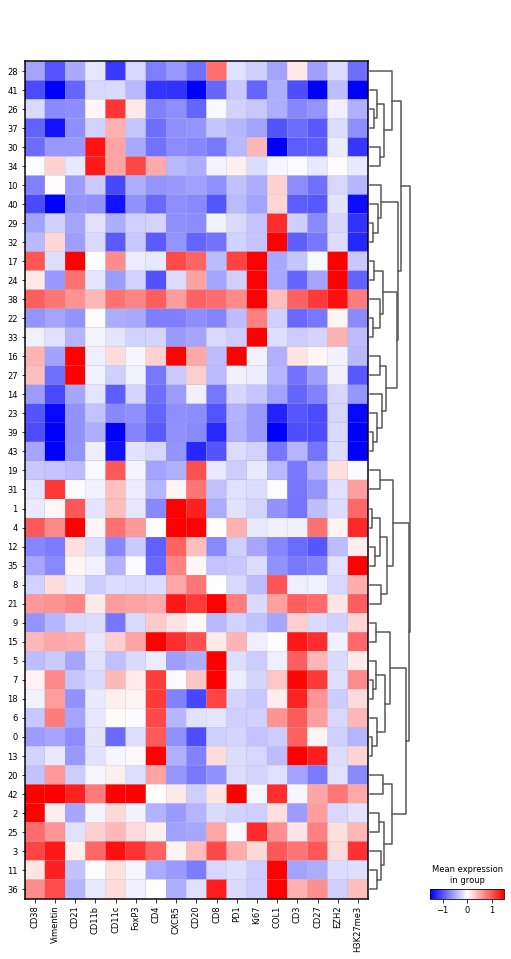

In [149]:
sc.pl.matrixplot(adata, adata.var_names, groupby='leiden', cmap='bwr', dendrogram=True, vmin=-1.5, vmax=1.5)

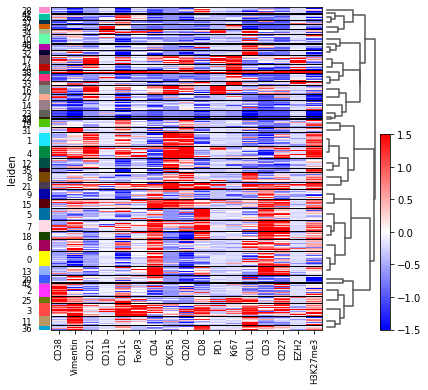

In [150]:
sc.pl.heatmap(adata, adata.var_names, groupby='leiden', cmap='bwr', dendrogram=True, vmin=-1.5, vmax=1.5)

# Plot cell mask

In [151]:
import matplotlib 
from PIL import Image

def create_clustered_cell(mask, label2cell, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols] = int(i)+1
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def create_colored_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


In [152]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [153]:
masks = {}
for d in donors:
    masks[d] = get_masks(data_dir / "masks" / d)

In [154]:
# size = 1000
# labels = adata.obs.leiden.cat.categories.tolist()

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for ii, l in enumerate(labels):
#             cell_id = adata_subset[adata_subset.obs.leiden == l].obs.Cell.to_list()
#             label2cell[ii] = cell_id

#         img = create_clustered_cell(mask, label2cell)
#         # img = mask[:size, :size]

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "unsupervised_clusters" / f"{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


In [155]:
var = 'leiden'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




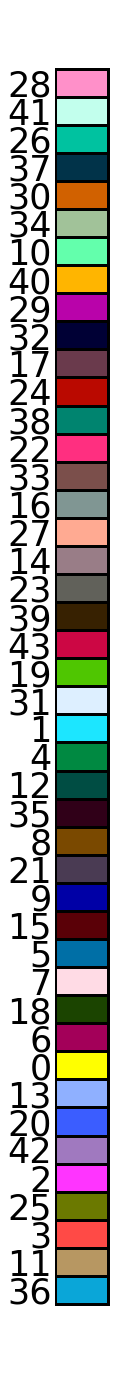

In [156]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,25))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [157]:
# size = 1000

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for ii,l in enumerate(labels):
#             cell_id = adata_subset[adata_subset.obs[var] == l].obs.Cell.to_list()
#             label2cell[ii] = cell_id

#         img = create_colored_cell(mask, label2cell, colors_rgb)

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "semi_supervised" / 'r1_colored' / f"{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


# Cluster annotation r1

In [158]:
path = data_dir / "semi-supervised" / "cluster_annotation_1.csv"

df = pd.read_csv(path) 

In [159]:
adata

AnnData object with n_obs × n_vars = 999970 × 17
    obs: 'ROI', 'Cell', 'Dataset', 'leiden'
    uns: 'Dataset_colors', 'leiden', 'neighbors', 'dendrogram_leiden', 'leiden_colors'
    obsm: 'X_scanorama', 'X_tsne', 'spatial'
    obsp: 'connectivities', 'distances'

In [160]:
# Get mapping from cluster numbers to Name
mapping = dict(zip(df.iloc[:,0].astype(str), df.iloc[:,1].astype(str)))

# Define new clusters
adata.obs["Phenotype_r1"] = (
    adata.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Phenotype_r1']`


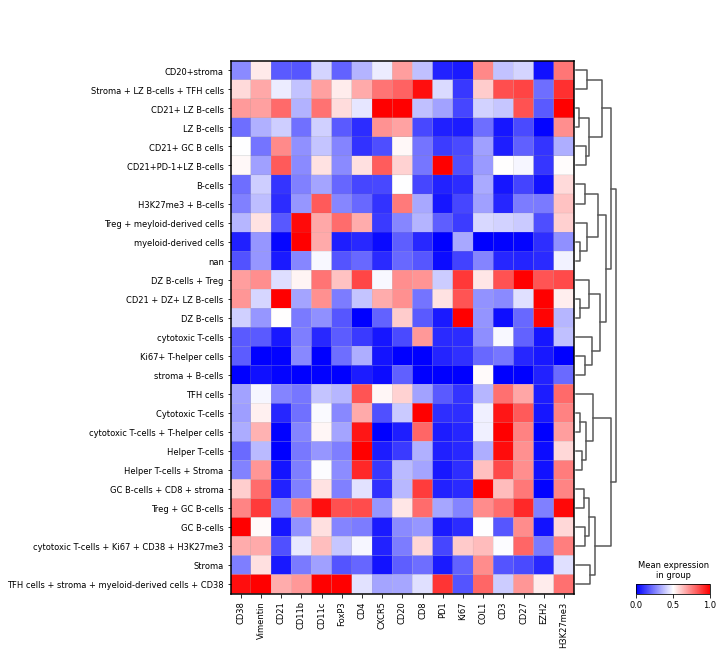

In [161]:
sc.tl.dendrogram(adata, groupby='Phenotype_r1')
sc.pl.matrixplot(adata, adata.var_names, groupby='Phenotype_r1', cmap='bwr', dendrogram=True, 
                 standard_scale='var')

In [162]:
# R1 mapping to number 
mapping_r1_n = dict(zip(adata.obs["Phenotype_r1"].unique(), range(len(adata.obs["Phenotype_r1"].unique()))))

# Define new clusters
adata.obs["Phenotype_r1_n"] = (
    adata.obs["Phenotype_r1"]
    .map(lambda x: mapping_r1_n.get(x, x))
    .astype("category")
)

In [163]:
# size = 1000
# labels = adata.obs["Phenotype_r1_n"].cat.categories.tolist()

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for ii, l in enumerate(labels):
#             cell_id = adata_subset[adata_subset.obs["Phenotype_r1_n"] == l].obs.Cell.to_list()
#             label2cell[l] = cell_id

#         img = create_clustered_cell(mask, label2cell)
#         # img = mask[:size, :size]

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "semi_supervised" / 'r1' / f"{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


### Pot clustered cell mask

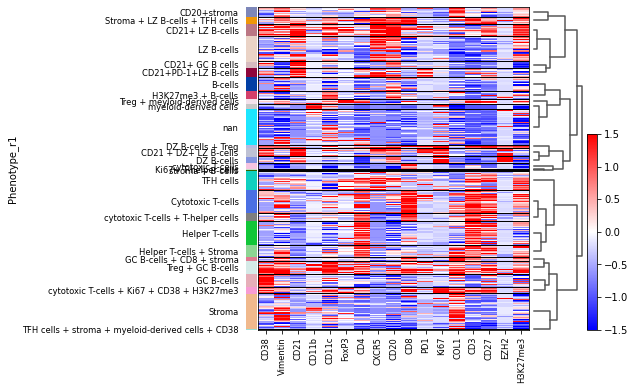

In [164]:
sc.pl.heatmap(adata, adata.var_names, groupby='Phenotype_r1', cmap='bwr', dendrogram=True, vmin=-1.5, vmax=1.5)

In [165]:
var = 'Phenotype_r1'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




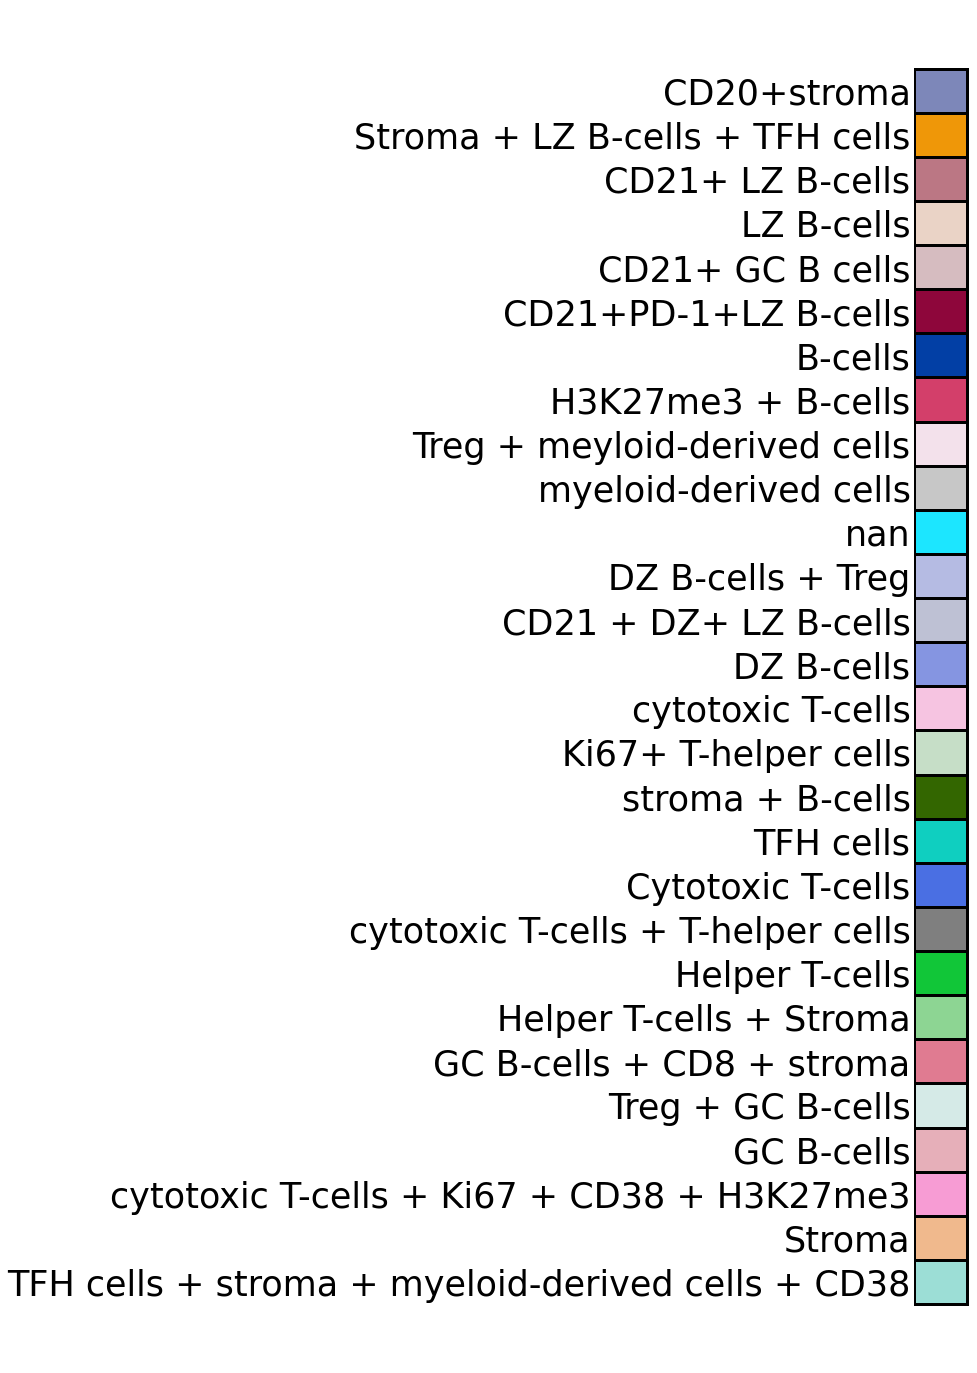

In [166]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,25))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [167]:
# size = 1000

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for ii,l in enumerate(labels):
#             cell_id = adata_subset[adata_subset.obs[var] == l].obs.Cell.to_list()
#             label2cell[ii] = cell_id

#         img = create_colored_cell(mask, label2cell, colors_rgb)

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "semi_supervised" / 'r2_colored' / f"{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


### Statistics

In [168]:
donors = adata.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata[adata.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['Phenotype_r1'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [169]:
df['Clusters'] = df.index.map(lambda x: mapping_r1_n.get(x, x))

In [170]:
df.to_clipboard()

In [171]:
df

,LN Donor A,LN Donor E,INT Donor B,INT Donor E,TS Donor A,TS Donor E,Clusters
Stroma,18959,19214,17858,22137,13945,17200,0
Cytotoxic T-cells,14406,24432,9025,5243,8587,11212,12
nan,12294,6897,13625,40296,12907,24990,1
LZ B-cells,11776,20162,3106,7362,22134,13662,5
Helper T-cells,11246,24691,4006,1255,14273,18800,21
B-cells,7873,19538,1427,439,8677,7608,4
GC B-cells,6815,2966,2739,1650,9003,17092,15
CD20+stroma,5775,6251,5670,6075,4650,2471,9
CD21+ LZ B-cells,5730,8764,7897,8928,3982,2479,11
TFH cells,5629,6160,8842,11250,11041,15566,13


# Subset clustering

In [172]:
def subset_clustering(adata, name, cluster, var_names, r=0.4):
    adata_subset = adata[adata.obs[name] == cluster, var_names]
    sc.tl.leiden(adata_subset, resolution=r)
    return adata_subset

In [173]:
# For each selected cluster save the new mapping
new_mapping = {}

running Leiden clustering


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:41)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


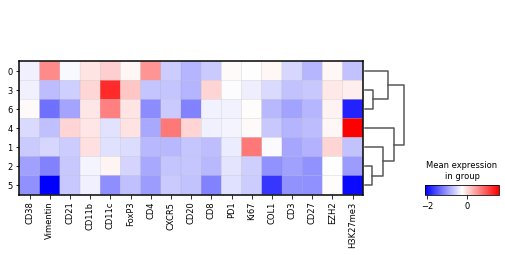

['Stroma', 'Other', 'DZ B-cells', 'LZ B-cells', 'myeloid-derived cells']
Categories (5, object): ['DZ B-cells', 'LZ B-cells', 'Other', 'Stroma', 'myeloid-derived cells']


In [174]:
cluster = 1

markers = adata.var_names.tolist()
adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.35)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', 
                 dendrogram=True)

mapping = dict(zip(
    ['0', '1', '2', '3', '4', '5', '6'], 
    ['Stroma', 'DZ B-cells', 'Other', 'myeloid-derived cells',
    'LZ B-cells', 'Other', 'myeloid-derived cells']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:16)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


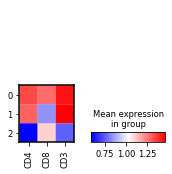

['Cytotoxic T-cells', 'Helper T cells']
Categories (2, object): ['Cytotoxic T-cells', 'Helper T cells']


In [175]:
cluster = 3
markers = ['CD4','CD8', 'CD3']

adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.25)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr')

mapping = dict(zip(
    ['0', '1', '2'], 
    ['Helper T cells', 'Helper T cells', 'Cytotoxic T-cells']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


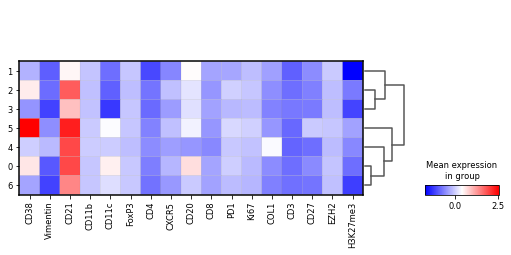

['FDC', 'LZ B-cells']
Categories (2, object): ['FDC', 'LZ B-cells']


In [176]:
cluster = 10
markers = adata.var_names.tolist()

adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.45)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', dendrogram=True)

mapping = dict(zip(
    ['0', '1', '2', '3', '4', '5', '6'], 
    ['FDC', 'LZ B-cells',  'FDC', 'LZ B-cells', 
    'FDC', 'FDC', 'FDC',]
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


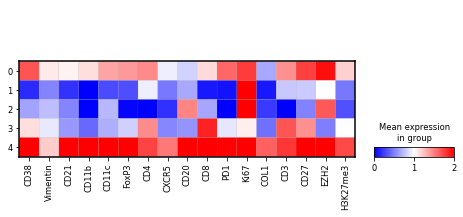

['DZ B-cells', 'TFH', 'Exhausted T-cells']
Categories (3, object): ['DZ B-cells', 'Exhausted T-cells', 'TFH']


In [177]:
cluster = 19
markers = adata.var_names.tolist()
adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.35)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', vmin=0, vmax=2)

mapping = dict(zip(
    ['0', '1', '2', '3', '4'], 
    ['TFH', 'DZ B-cells', 'DZ B-cells', 'Exhausted T-cells', 'Exhausted T-cells']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:15)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


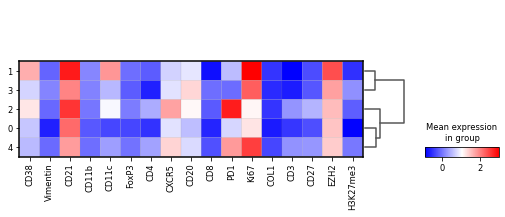

['TFH', 'DZ B-cells', 'FDC']
Categories (3, object): ['DZ B-cells', 'FDC', 'TFH']


In [178]:
cluster = 20
markers = adata.var_names.tolist()

adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.45)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', dendrogram=True)

mapping = dict(zip(
    ['0', '1', '2', '3', '4'], 
    ['FDC', 'DZ B-cells', 'TFH', 'DZ B-cells', 'DZ B-cells']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


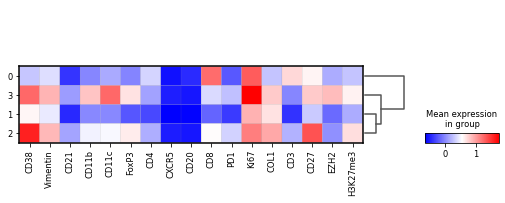

['Activated B', 'Cytotoxic T-cells']
Categories (2, object): ['Activated B', 'Cytotoxic T-cells']


In [179]:
cluster = 22
markers = adata.var_names.tolist()

adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster , markers, r=0.35)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', dendrogram=True)

mapping = dict(zip(
    ['0', '1', '2', '3'], 
    ['Cytotoxic T-cells', 'Activated B', 'Activated B', 'Activated B']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


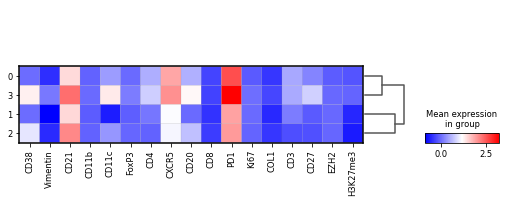

['TFH', 'FDC']
Categories (2, object): ['FDC', 'TFH']


In [180]:
cluster = 23
markers = adata.var_names.tolist()

adata_subset = subset_clustering(adata, 'Phenotype_r1_n', cluster, markers, r=0.35)
sc.tl.dendrogram(adata_subset, groupby='leiden')
sc.pl.matrixplot(adata_subset, adata_subset.var_names, groupby='leiden', cmap='bwr', dendrogram=True)

mapping = dict(zip(
    ['0', '1', '2', '3'], 
    ['TFH', 'FDC', 'TFH', 'FDC']
))
# Define new clusters
adata_subset.obs["Cell Type"] = (
    adata_subset.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

new_mapping[cluster] = adata_subset.obs["Cell Type"]
print(adata_subset.obs["Cell Type"].unique())

In [181]:
cluster2name = {
    2: 'Stroma Vimentin+',
    6: 'myeloid-derived cells',
    7: 'B-cells',
    8: 'Treg',
    9: 'B-cells MZ',
    11: 'LZ B-cells',
    15: 'CD38+', 
    16: 'TFH cells',
    17: 'Helper T', 
    24: 'Stroma',
    26: 'Helper T',
    27: 'Other'
}

In [182]:
# Get new mapping 
obs_df = sc.get.obs_df(adata, keys=adata.obs.columns.tolist())
obs_df['Phenotype'] = obs_df['Phenotype_r1'].tolist()

for cluster, new_labels in new_mapping.items():
    obs_df.loc[new_labels.index, 'Phenotype'] = new_labels.tolist()

# Direct change of cluster name
for cluster, new_label in cluster2name.items():
    obs_df.loc[obs_df['Phenotype_r1_n'] == cluster, 'Phenotype'] = new_label

obs_df['Phenotype'] = obs_df['Phenotype'].astype('category')

In [183]:
for n in obs_df['Phenotype'].unique():
    print(n)

Stroma
Stroma Vimentin+
Cytotoxic T-cells
B-cells
LZ B-cells
myeloid-derived cells
Treg
B-cells MZ
FDC
Other
TFH cells
CD38+
DZ B-cells
Helper T
cytotoxic T-cells
TFH
Helper T-cells
Activated B
Helper T cells
Exhausted T-cells


# Plot R2 clustered cell mask

In [184]:
adata.obs = obs_df

In [185]:
mapping = dict(zip(
    ['Helper T', 'Helper T cells', 'cytotoxic T-cells', 'TFH cells'], 
    ['Helper T-cells', 'Helper T-cells','Cytotoxic T-cells', 'TFH']
))

# Define new clusters
adata.obs["Phenotype"] = (
    adata.obs["Phenotype"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)


In [186]:
np.unique(adata.obs['Phenotype'])

array(['Activated B', 'B-cells', 'B-cells MZ', 'CD38+',
       'Cytotoxic T-cells', 'DZ B-cells', 'Exhausted T-cells', 'FDC',
       'Helper T-cells', 'LZ B-cells', 'Other', 'Stroma',
       'Stroma Vimentin+', 'TFH', 'Treg', 'myeloid-derived cells'],
      dtype=object)

In [187]:
# size = 1000
# labels = adata.obs.Phenotype.cat.categories.tolist()

# for d in adata.obs.Dataset.unique():
#     adata_donor = adata[adata.obs.Dataset == d, :]

#     # Create combined images
#     y_max, x_max = get_img_size(arrangement[d])
#     img_combined = np.zeros((y_max, x_max), dtype=np.uint8)

#     for i in adata_donor.obs.ROI.unique():
#         if i not in arrangement[d].keys():
#             continue

#         # Get dataset
#         adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

#         # Get mask
#         mask = masks[d][str(int(i))]

#         # Get label2cell dict
#         label2cell = {}
#         for ii, l in enumerate(labels):
#             cell_id = adata_subset[adata_subset.obs.Phenotype == l].obs.Cell.to_list()
#             label2cell[ii] = cell_id

#         img = create_clustered_cell(mask, label2cell)
#         # img = mask[:size, :size]

#         # Insert to combine image
#         y = max(0, arrangement[d][i][0] - 1)
#         x = max(0, arrangement[d][i][1] - 1)
#         img_combined[y : y + size, x : x + size] = img

#     save_path = p_dir / "figures" / "semi_supervised" / 'r2' / f"{d}.png"
#     img_combined = Image.fromarray(img_combined)
#     img_combined.save(save_path)


## Colored Final clusters clusters

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Phenotype']`


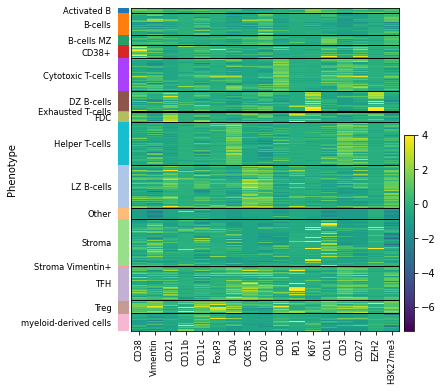

In [188]:
sc.tl.dendrogram(adata, groupby='Phenotype')
sc.pl.heatmap(adata, adata.var_names, groupby='Phenotype')

In [189]:
var = 'Phenotype'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




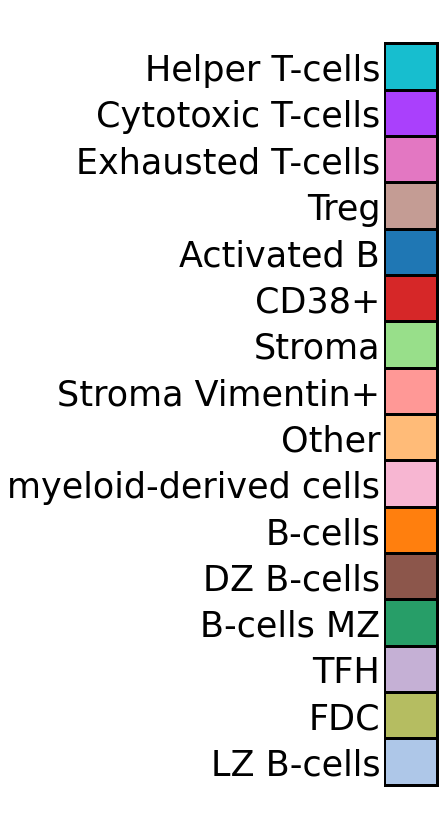

In [190]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,15))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


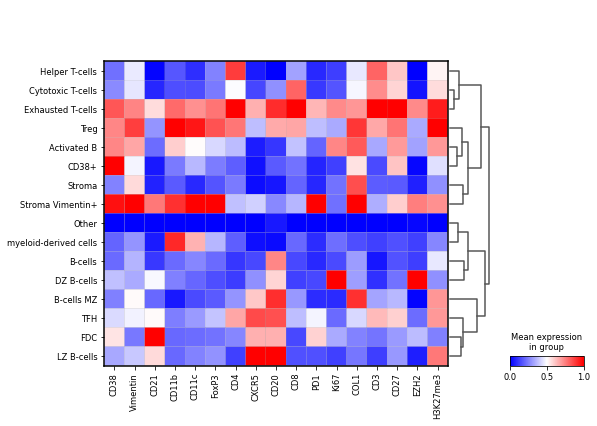

In [191]:
sc.pl.matrixplot(adata, adata.var_names, groupby='Phenotype', cmap='bwr', dendrogram=True, 
                 standard_scale='var')

In [192]:
colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

In [193]:
size = 1000

for d in adata.obs.Dataset.unique():
    adata_donor = adata[adata.obs.Dataset == d, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[d])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[d].keys():
            continue

        # Get dataset
        adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

        # Get mask
        mask = masks[d][str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for ii,l in enumerate(labels):
            cell_id = adata_subset[adata_subset.obs[var] == l].obs.Cell.to_list()
            label2cell[ii] = cell_id

        img = create_colored_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[d][i][0] - 1)
        x = max(0, arrangement[d][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "semi_supervised" / 'clustered_final' / f"{d}.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [194]:
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata.write(adata_path)

## Stats

In [195]:
donors = adata.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata[adata.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['Phenotype'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [198]:
df.to_clipboard()

In [199]:
df

,LN Donor A,LN Donor E,INT Donor B,INT Donor E,TS Donor A,TS Donor E
Stroma,30560,26725,19929,24339,19494,24375
Cytotoxic T-cells,18469,38770,11024,8793,11841,13483
LZ B-cells,17883,29570,11036,16293,26730,33748
Helper T-cells,16566,35307,7264,4220,27080,41345
B-cells,9534,22503,1785,526,14649,20691
TFH,8874,10565,14911,21468,17652,31780
CD38+,6815,2966,2739,1650,9003,17092
myeloid-derived cells,5815,3489,18449,11020,5205,9415
B-cells MZ,5775,6251,5670,6075,4650,2471
Treg,2945,4826,3529,8207,18836,1591
